# A deep dive in the code

In this tutorial, you will do a dive into the `MACE` code, which is a highly accurate and efficient MLIP. If you would like to understand this method in more detail, you can find the [original method paper](https://proceedings.neurips.cc/paper_files/paper/2022/file/4a36c3c51af11ed9f34615b81edb5bbc-Paper-Conference.pdf). MACE is a Message Passing Neural Network (MPNNs) Interatomic Potential that forms equivariant many body messages.

MACE was developed by unifying the Atomic Cluster Expansion (ACE) approach with the equivariant MPNNs. The mathematical formalism which unifies these methods is explained in the [accompaning paper](https://doi.org/10.48550/arXiv.2205.06643). Another [useful reference](
https://doi.org/10.1063/5.0155322) showcases the methods performance on published benchmark datasets aswell as updated set of equations that we will follow in this notebook.  The [code implementation](https://github.com/ACEsuit/mace) is publically available and [here](https://mace-docs.readthedocs.io/en/latest/) you can find the accompaning documentation.

The tutorial was developed by [Ilyes Batatia at University of Cambridge](https://github.com/ilyes319/mace-tutorials/)

## Create Model

We will first create a model that we will dissect afterwards.

In [1]:
import numpy as np
import torch
import torch.nn.functional
from e3nn import o3
from matplotlib import pyplot as plt
%matplotlib inline

from mace import data, modules, tools
from mace.tools import torch_geometric

In [2]:
z_table = tools.AtomicNumberTable([1, 8])
atomic_energies = np.array([-1.0, -3.0], dtype=float)
cutoff = 3

model_config = dict(
        num_elements=2,  # number of chemical elements
        atomic_energies=atomic_energies,  # atomic energies used for normalisation
        avg_num_neighbors=8,  # avg number of neighbours of the atoms, used for internal normalisation of messages
        atomic_numbers=z_table.zs,  # atomic numbers, used to specify chemical element embeddings of the model
        r_max=cutoff,  # cutoff
        num_bessel=8,  # number of radial features
        num_polynomial_cutoff=6,  # smoothness of the radial cutoff
        max_ell=2,  # expansion order of spherical harmonic adge attributes
        num_interactions=2,  # number of layers, typically 2
        interaction_cls_first=modules.interaction_classes[
            "RealAgnosticResidualInteractionBlock"
        ],  # interation block of first layer
        interaction_cls=modules.interaction_classes[
            "RealAgnosticResidualInteractionBlock"
        ],  # interaction block of subsequent layers
        hidden_irreps=o3.Irreps("32x0e + 32x1o"),  # 32: number of embedding channels, 0e, 1o is specifying which equivariant messages to use. Here up to L_max=1
        correlation=3,  # correlation order of the messages (body order - 1)
        MLP_irreps=o3.Irreps("16x0e"),  # number of hidden dimensions of last layer readout MLP
        gate=torch.nn.functional.silu,  # nonlinearity used in last layer readout MLP
    )
model = modules.MACE(**model_config)

/opt/conda/lib/python3.10/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/jit/_check.py:177: Us

In [3]:
print(model)

MACE(
  (node_embedding): LinearNodeEmbeddingBlock(
    (linear): Linear(2x0e -> 32x0e | 64 weights)
  )
  (radial_embedding): RadialEmbeddingBlock(
    (bessel_fn): BesselBasis(r_max=3.0, num_basis=8, trainable=False)
    (cutoff_fn): PolynomialCutoff(p=6.0, r_max=3.0)
  )
  (spherical_harmonics): SphericalHarmonics()
  (atomic_energies_fn): AtomicEnergiesBlock(energies=[-1.0000, -3.0000])
  (interactions): ModuleList(
    (0): RealAgnosticResidualInteractionBlock(
      (linear_up): Linear(32x0e -> 32x0e | 1024 weights)
      (conv_tp): TensorProduct(32x0e x 1x0e+1x1o+1x2e -> 32x0e+32x1o+32x2e | 96 paths | 96 weights)
      (conv_tp_weights): FullyConnectedNet[8, 64, 64, 64, 96]
      (linear): Linear(32x0e+32x1o+32x2e -> 32x0e+32x1o+32x2e | 3072 weights)
      (skip_tp): FullyConnectedTensorProduct(32x0e x 2x0e -> 32x0e+32x1o | 2048 paths | 2048 weights)
      (reshape): reshape_irreps()
    )
    (1): RealAgnosticResidualInteractionBlock(
      (linear_up): Linear(32x0e+32x1o -> 32

We should also create a graph object of a dummy water molecule for demonstration:

In [4]:
config = data.Configuration(
    atomic_numbers=np.array([8, 1, 1]),
    positions=np.array(
        [
            [0.0, -2.0, 0.0],
            [1.0, 0.0, 0.0],
            [0.0, 1.0, 0.0],
        ]
    ),
    forces=np.array(
        [
            [0.0, -1.3, 0.0],
            [1.0, 0.2, 0.0],
            [0.0, 1.1, 0.3],
        ]
    ),
    energy=-1.5,
)

atomic_data = data.AtomicData.from_config(config, z_table=z_table, cutoff=float(model.r_max))
data_loader = torch_geometric.dataloader.DataLoader(
        dataset=[atomic_data],
        batch_size=1,
        shuffle=True,
        drop_last=False,
    )
batch = next(iter(data_loader))
print("The data is stored in batches. Each batch is a single graph, potentially made up of several disjointed sub-graphs corresponding to different chemical structures. ")
print(batch)
print("\nbatch.edge_index contains which atoms are connected within the cutoff. It is the adjacency matrix in sparse format.\n")
print(batch.edge_index)

The data is stored in batches. Each batch is a single graph, potentially made up of several disjointed sub-graphs corresponding to different chemical structures. 
Batch(batch=[3], cell=[3, 3], edge_index=[2, 4], energy=[1], energy_weight=[1], forces=[3, 3], forces_weight=[1], node_attrs=[3, 2], positions=[3, 3], ptr=[2], shifts=[4, 3], stress_weight=[1], unit_shifts=[4, 3], virials_weight=[1], weight=[1])

batch.edge_index contains which atoms are connected within the cutoff. It is the adjacency matrix in sparse format.

tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])


# A deep dive in the code


## The embeddings

### Spherical Harmonics
The real spherical harmonics expand the angular degree of freedom in a basis that are index by $lm$ indices. We describe the angular part as a unit vector $\hat{r}_{ij} := \frac{r_{i} - r_{j}}{||r_{i} - r_{j}||_{2}}$ and the spherical harmonics are defined as polynomial functions of $\hat{r}$ that are orthonormal.

Let's first create a random set of points on the unit sphere and plot them.

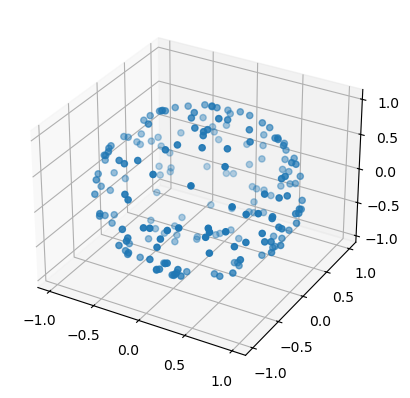

In [5]:
# create random set of points on the unit sphere and plot them
n = 200
points = torch.randn(n, 3)
points = points / points.norm(dim=-1, keepdim=True)
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
plt.show()

The order of the expansion in controlled by $l_{\text{max}}$ and the number of basis functions is $(l_{\text{max}} + 1)^{2}$. Let's see what $l_{\text{max}}$ is used in this model.

In [6]:
l_max = model.spherical_harmonics._lmax
print("l_max =",l_max)
# It should return 2 for the example model

l_max = 2


One important aspect of spherical harmonics is their normalization. In MACE, we use the **component** normalization satisfying:
$$||Y_{l}||^{2} = 2l + 1$$
Let's pass now the points to the spherical harmonics and check the normalization and the shape.
In the model's code, the unit vectors expanded in the spherical harmonics basis are named **edge_attrs**.

In [7]:
edge_attrs = model.spherical_harmonics(points)
print("shape:", edge_attrs.shape)
print("number of edges:", edge_attrs.shape[0])
print("number of features: (2l + 1)^2=", edge_attrs.shape[1])

# Compute the norm of the different irreps of the spherical harmonics for the first edge
norm_0 = edge_attrs[0, 0].norm() ** 2
print("norm of the 0th irrep: 2*0 + 1 =", int(np.round(norm_0.item())))
norm_1 = edge_attrs[0, 1:4].norm() ** 2
print("norm of the 1st irrep: 2*1 + 1 =", int(np.round(norm_1.item())))
norm_2 = edge_attrs[0, 4:9].norm() ** 2
print("norm of the 2nd irrep: 2*2 + 1 =", int(np.round(norm_2.item())))

shape: torch.Size([200, 9])
number of edges: 200
number of features: (2l + 1)^2= 9
norm of the 0th irrep: 2*0 + 1 = 1
norm of the 1st irrep: 2*1 + 1 = 3
norm of the 2nd irrep: 2*2 + 1 = 5


The spherical harmonics evaluated this way are stored as edge attributes and will be used in the interaction block to compute the 1-particle basis and the message. Below is the relevant code snippet for the example water config to compute $Y^{m_{1}}_{l_{1}} (\boldsymbol{\hat{r}}_{ij})$ :

In [8]:
vectors, lengths = modules.utils.get_edge_vectors_and_lengths(
            positions=batch["positions"],
            edge_index=batch["edge_index"],
            shifts=batch["shifts"],
        )
edge_attrs = model.spherical_harmonics(vectors)
print(f"The edge attributes have shape (num_edges, num_spherical_harmonics)\n", edge_attrs.shape)

The edge attributes have shape (num_edges, num_spherical_harmonics)
 torch.Size([4, 9])


### Radial Basis
The edge features are scalars, typically 8 Bessel basis functions evaluated on the distance between the atoms. They are implemented in `mace/modules/radial.py`:

```py
class BesselBasis(torch.nn.Module)
```


In [9]:
model.radial_embedding

RadialEmbeddingBlock(
  (bessel_fn): BesselBasis(r_max=3.0, num_basis=8, trainable=False)
  (cutoff_fn): PolynomialCutoff(p=6.0, r_max=3.0)
)

This implements the following basis functions:

$j^{n}_{0} (r_{ij}) =  \sqrt{\frac{2}{r_{\text{cut}}}} \frac{\sin{\left(n\pi\frac{r_{ij}}{r_{\text{cut}}} \right)}}{r_{ij}} f_{\text{cut}}(r_{ij})$

We can plot the 8 Bessel basis functions corresponding to $n=0$ to $n=7$:

In [10]:
dists = torch.tensor(np.linspace(0.1, 5.5, 100), dtype=torch.get_default_dtype()).unsqueeze(-1)

radials = model.radial_embedding(dists)

for i in range(radials.shape[1]):
    plt.plot(dists, radials[:, i], label=f'Radial {i}')

# Add title, labels, and legend
plt.title("8 Bessel basis functions")
plt.xlabel("distance / A")
plt.ylabel("Value")
plt.legend()

# Display the plot
plt.show()

TypeError: RadialEmbeddingBlock.forward() missing 3 required positional arguments: 'node_attrs', 'edge_index', and 'atomic_numbers'

The radial basis is evaluated on the distances and is stored as edge features to be used later in the interaction block to compute the 1-particle basis.

In [ ]:
edge_feats = model.radial_embedding(lengths)
print("The edge features have shape (num_edges, num_radials)")
print(edge_feats.shape)

### Node Embedding
Next we look at the `LinearNodeEmbeddingBlock` implemented in `mace/modules/blocks.py`

```py
class LinearNodeEmbeddingBlock(torch.nn.Module):
```

The node attributes are integers that correspond to the chemical elements. They are prepared during the data loading (input preparation) phase using the `z_table` specifying the model chemical elements. This is part of creating the batch object.

In [ ]:
atomic_numbers = [8, 1, 1]  # the atomic numbers of the structure evaluated
indices = tools.utils.atomic_numbers_to_indices(atomic_numbers, z_table=z_table)
node_attrs = tools.torch_tools.to_one_hot(
            torch.tensor(indices, dtype=torch.long).unsqueeze(-1),
            num_classes=len(z_table),
        )
print(node_attrs)  # node attributes are the one hot encoding of the chemical  elements of each node

In [ ]:
model.node_embedding  # node embedding block of the model mapping the one-hot (2 dimensional because we have two chemical elements) to 32 channels using a learnable linear

In [ ]:
print("Weights are internally flattened and have a shape",
      model.node_embedding.linear.__dict__['_parameters']['weight'].shape)

print("\nThis corresponds to (num_chemical_elements, num_channels) learnable embeddings for each chemical element with shape:",
      model.node_embedding.linear.__dict__['_parameters']['weight'].reshape((2, 32)).shape)

Next is the implementation of forming the intial node embeddings:

 $h_{i,k00}^{(0)} = \sum_z W_{kz} \delta_{zz_{i}}$

In [ ]:
# In MACE we create the initial node features using this block:
node_feats = model.node_embedding(node_attrs)

# chemical elements are embedded into 32 channels of the model. These 32 numbers are the initial node features.
print("The node embedding block returns (num_atoms, num_channels) shaped tensor:", node_feats.shape)

These initial node features will be used in the 1-particle basis of the interaction block.

## Interaction Blocks

The interaction blocks is used to create the **sketched** atomic basis $A_{iklm}$ for each atoms $i$ at each layer $s$.
Different interaction blocks can be used, but the two defaults are the   **RealAgnosticInteractionBlock** for the first layer and **RealAgnosticResidualInteractionBlock** implemented in `mace/modules/blocks.py`.
```py
class RealAgnosticResidualInteractionBlock()
```
Here we will analyse the interaction block used in the model at the first layer.

In [ ]:
print(model.interactions[0])

It has four steps:
1. Linearly mixing the incoming node features: $\bar{h}^{(s)}_{i,kl_2m_2} = \sum_{\tilde{k}} W_{k\tilde{k}l_2}^{(s)} h^{(s)}_{i,\tilde{k}l_2m_2}$

In [ ]:
print(model.interactions[0].linear_up)
node_feats = model.interactions[0].linear_up(node_feats)
print(node_feats.shape)

2. Construct the learnable radial basis using the Bessel Basis and the radial **MLP**:
$    R_{k \eta_{1} l_{1}l_{2} l_{3}}^{(s)}(r_{ij}) =   {\rm MLP}\left( \left\{ {j_0^n} (r_{ij})\right\}_{n}\right)$


In [ ]:
print(model.interactions[0].conv_tp_weights)
# We go from 8 Bessel channels, to three layers of 64 channels, to 224 channels representing all the paths in the tensor product of the two irreps
tp_weights = model.interactions[0].conv_tp_weights(edge_feats)
print(tp_weights.shape)

At this point it is possible to plot the MACE learnt radial functions (Note that here the model is untrained)

In [ ]:
dists = torch.tensor(np.linspace(0.1, 5.5, 100), dtype=torch.get_default_dtype()).unsqueeze(-1)

edge_feats_scan = model.radial_embedding(dists)

tp_weights_scan = model.interactions[0].conv_tp_weights(edge_feats_scan).detach().numpy()

num_basis_to_print = 5
for i in range(num_basis_to_print):
    plt.plot(dists, tp_weights_scan[:, i], label=f'Learnable Radial {i}')

# Add title, labels, and legend
plt.title("MACE learnable radial functions (untrained)")
plt.xlabel("distance / A")
plt.ylabel("Value")
plt.legend()

# Display the plot
plt.show()

3. The formation of the one particle basis  $\phi_{ij,k \eta_{1} l_{3}m_{3}}^{(s)} = \sum_{l_1l_2m_1m_2} C_{\eta_1,l_1m_1l_2m_2}^{l_3m_3}R_{k \eta_{1}l_{1}l_{2}l_{3}}^{(s)}(r_{ij})  Y^{m_{1}}_{l_{1}} (\boldsymbol{\hat{r}}_{ij}) \bar{h}^{(s)}_{j,kl_2m_2}$.

In [ ]:
print(model.interactions[0].conv_tp)
sender, receiver = batch["edge_index"] # use the graph to get the sender and receiver indices
mji = model.interactions[0].conv_tp(
            node_feats[sender], edge_attrs, tp_weights
        )
print("The first dimension is the number of edges, highlighted by the ij in the variable name", mji.shape)
print(f"The second dimension is num_channels * num_paths dimensional, in this case: {mji.shape[-1]} = 32 * {mji.shape[-1] // 32}", )

4. The sum over the neighbors of atom $i$ to form the atomic basis $\sum_{j \in \mathcal{N}(i)} \phi_{ij,k \eta_{1} l_{3}m_{3}}^{(s)}$.

In [ ]:
from mace.tools.scatter import scatter_sum
message = scatter_sum(
            src=mji, index=receiver, dim=0, dim_size=node_feats.shape[0]
        )
print("The messages have first dimension corresponding to the nodes i:", message.shape)

5. The linear sketching that mixes the channels to form  $A_{i,kl_{3}m_{3}}^{(s)} = \sum_{\tilde{k}, \eta_{1}} W_{k \tilde{k} \eta_{1}l_{3}}^{(s)}\sum_{j \in \mathcal{N}(i)}  \phi_{ij,\tilde{k} \eta_{1} l_{3}m_{3}}^{(s)}$.
    
    For the first layer **only**, these weights are species dependent (hence the last module called skip_tp) but we will show the default case here:

In [ ]:
node_feats = model.interactions[0].linear(message)
print("This step leaves the shape unchanged:", message.shape)

## Equivariant Symmetric Product Basis

$$  {m}_i^{(t)} =
  \sum_j {u}_1 \left( \sigma_i^{(t)}; \sigma_j^{(t)} \right)
  + \sum_{j_1, j_2} {u}_2 \left(\sigma_i^{(t)}; \sigma_{j_1}^{(t)}, \sigma_{j_2}^{(t)} \right)
  + \dots +
  \sum_{j_1, \dots, j_{\nu}} {u}_{\nu} \left( \sigma_i^{(t)}; \sigma_{j_1}^{(t)}, \dots, \sigma_{j_{\nu}}^{(t)} \right)$$

The equivariant symmetric product is implemented in `mace/modules/symmetric_contraction.py` and is called **SymmetricContraction**.

```py
class SymmetricContraction(CodeGenMixin, torch.nn.Module):
```

The key operation of MACE is the efficient construction of higher order features from the ${A}_{i}^{(t)}$-features.
This is achieved by first forming tensor products of the features, and then symmetrising:

$$
  {B}^{(t)}_{i,\eta_{\nu} k LM}
  = \sum_{{l}{m}} \mathcal{C}^{LM}_{\eta_{\nu}, l m} \prod_{\xi = 1}^{\nu} A_{i,k l_\xi  m_\xi}^{(t)}, \quad {l}{m} = (l_{1}m_{1},\dots,l_{\nu}m_{\nu})
  $$

And then summing the basis with learnable weights to form the many body equivariant messages:

$$m_{i,k LM}^{(t)} =  \sum_{\nu} \sum_{\eta_{\nu}} W_{z_{i}k L, \eta_{\nu}}^{(t)} {B}^{(t)}_{i,\eta_{\nu} k LM}$$


In [ ]:
print(model.products[0].symmetric_contractions)

In [ ]:
node_feats = model.interactions[0].reshape(message)
print("Input shape", node_feats.shape)
node_feats = model.products[0](node_feats=node_feats, sc=None, node_attrs=batch["node_attrs"])
print("Output shape", message.shape)

Each **Contraction** submodules of the **SymmetricContraction** module is responsible for the construction of the basis for a given equivariant output $LM$.
One can print the shape of the different weights $W_{z_{i}k L, \eta_{\nu}}^{(t)}$ stored in this submodule. These weights have shape $[N_{\text{elements}},N_{\text{path}},N_{\text{channels}}]$. The number $N_{\text{path}}$ is a function of the output $LM$ and the correlation order $\nu$, and $l_{\text{max}}$.

In [ ]:
print("nu = 3 :",model.products[0].symmetric_contractions.contractions[0].__dict__["_parameters"]["weights_max"].shape)
print("nu = 2 :",model.products[0].symmetric_contractions.contractions[0].weights[0].shape)
print("nu = 1 :",model.products[0].symmetric_contractions.contractions[0].weights[1].shape)

## MACE readout

To create the output of the model we use the node features from all layers $s$:

\begin{equation*}
    \mathcal{R}^{(s)} \left( \boldsymbol{h}_i^{(s)} \right) =
    \begin{cases}
      \sum_{k}W^{(s)}_{k}h^{(s)}_{i,k00}     & \text{if} \;\; 1 < s < S \\[13pt]
      {\rm MLP} \left( \left\{ h^{(s)}_{i,k00} \right\}_k \right)  &\text{if} \;\; s = S
    \end{cases}
\end{equation*}

The first linear readout is implemented in

```py
class LinearReadoutBlock(torch.nn.Module):
```

In our example case this maps the 32 dimensional $h^{(1)}_{i,k00}$, the invariant part os the node features after the first interaction to the first term in the aotmic site energy:

In [ ]:
print(model.readouts[0])

In [ ]:
node_energies = model.readouts[0](node_feats).squeeze(-1)

The last layer readout block is a 1 hidden layer Multi Layer Percptron (MLP):

```py
class NonLinearReadoutBlock(torch.nn.Module):
```

In [ ]:
print(model.readouts[1])

It is also possible to have equivariant readouts. This can be achieved by using Gated non-linearities. See as an example:

```py
class NonLinearDipoleReadoutBlock(torch.nn.Module):
```

These readouts are formed for each node in the batch. To turn them into a graph level readout we use a scatter sum operation which sums the node energies for each graph (separate chemical strucutre) in the batch. This is followed by summing the atomic energy and 1-st, 2nd etc. layer contributions to form the final model output.

In [ ]:
energy = scatter_sum(
                src=node_energies, index=batch["batch"], dim=-1, dim_size=batch.num_graphs
            )  # [n_graphs,]
# in the code this step is done for each layer followed by summing the layer-wise output
print("Energy:",energy)